In [535]:
import networkx as nx
import cirq
import cirq_google
import numpy as np
from matplotlib import pyplot as plt

In [801]:
class Gate:
    def __init__(self, gname, *args):
        self.name = gname
        self.qs = []
        for i in args:
            self.qs.append(i)
    
    def apply(self, *qubits):
        return getattr(cirq, self.name)(qubits)

def choose_oneq_gates(gates, depth):
    #Chooses one one-qubit gate from given for each step in range(depth)
    ans = []
    probs = [len(gates) for i in range(len(gates))]
    for i in range(depth):
        gate = np.random.choice(gates, p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
        probs[gates.index(gate)] += len(gates)
        ans.append(gate)
    return ans

def choose_qubits_for_CZ(depth, num_q):
    #Chooses qubits to apply CZ to for each step in range(depth)
    ans = []
    if num_q == 2:
        vrs = [[0], []]
        probs = [2 for i in range(2)]
    elif num_q == 3:
        vrs = [[0], [1]]
        probs = [2 for i in range(2)]
    elif num_q == 4:
        vrs = [[0, 2], [1]]
        probs = [2 for i in range(2)]
    elif num_q == 5:
        vrs = [[0, 2], [0, 3], [1, 3]]
        probs = [3 for i in range(3)]
    ans = []
    for i in range(depth):
        qs = np.random.choice([i for i in range(len(probs))], p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
        probs[qs] += len(vrs)
        ans.append(np.array(vrs[qs]))
    return ans

### Generate Gate Sequence

In [802]:
num_q = 5
depth = 3

oneq_gates = ["T", "rx", "ry"]
seq_oneq_gates = choose_oneq_gates(oneq_gates, depth)
seq_cz_qubits = choose_qubits_for_CZ(depth, num_q)

gates = []
nodes = []

for i in range(num_q):
    gates.append(Gate("H", i))
    nodes.append((i, {"subset" : 0}))

cnt = num_q
for i in range(depth):
    for v in range(num_q):
        if v in seq_cz_qubits[i]:
            gates.append(Gate("CZ", v, v + 1))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1
        elif v not in seq_cz_qubits[i] and v not in seq_cz_qubits[i] + 1:
            gates.append(Gate(""))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1

    for j in range(num_q):
        gates.append(Gate(seq_oneq_gates[i], j))
        nodes.append((cnt, {"subset" : 2 * i + 2}))
        cnt += 1

In [803]:
# for g in gates:
#     print(g.name, g.qs)

### Create Graph

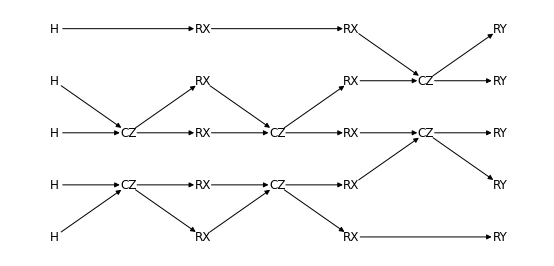

In [804]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

cur_gate = np.array([i for i in range(num_q)])
cur = num_q
for gate in gates[num_q:]:
    for i in gate.qs:
        G.add_edge(cur_gate[i], cur)
        cur_gate[i] = cur
    cur += 1
    
pos = nx.multipartite_layout(G)
labeldict = {}
for i in range(len(gates)):
    labeldict[i] = gates[i].name.upper()
nx.draw(G, pos, labels = labeldict, with_labels = True, node_color = 'none')

### Simulate on LineQubit

In [798]:
q_line = cirq.LineQubit.range(num_q)
line_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        line_circuit.append(getattr(cirq, gate.name)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 1:
        line_circuit.append(getattr(cirq, gate.name)(np.pi / 2)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 2:
        line_circuit.append(getattr(cirq, gate.name)(q_line[gate.qs[0]], q_line[gate.qs[1]]))
print(line_circuit)
#barier

0: ───H───@───T───@──────────Rx(0.5π)───@───T───
          │       │                     │
1: ───H───@───T───@──────────Rx(0.5π)───@───T───

2: ───H───T───────@──────────Rx(0.5π)───T───────
                  │
3: ───H───@───T───@──────────Rx(0.5π)───@───T───
          │                             │
4: ───H───@───T───Rx(0.5π)──────────────@───T───


In [790]:
sim = cirq.Simulator()
results_line = sim.simulate(line_circuit)
print(results_line)

measurements: (no measurements)
output vector: [-0.        +0.17677665j -0.12499996+0.12499996j -0.12499996+0.12499996j
  0.17677665+0.j         -0.12499996+0.12499996j -0.17677665-0.j
  0.17677665+0.j         -0.12499996-0.12499996j -0.12499996+0.12499996j
 -0.17677665+0.j         -0.17677665+0.j          0.12499996+0.12499996j
 -0.17677665+0.j         -0.12499996-0.12499996j  0.12499996+0.12499996j
  0.        -0.17677665j -0.12499996+0.12499996j -0.17677665+0.j
 -0.17677665+0.j          0.12499996+0.12499996j -0.17677665+0.j
 -0.12499996-0.12499996j  0.12499996+0.12499996j  0.        -0.17677665j
 -0.17677665-0.j         -0.12499996-0.12499996j -0.12499996-0.12499996j
  0.        +0.17677665j -0.12499996-0.12499996j  0.        -0.17677665j
  0.        +0.17677665j  0.12499996-0.12499996j]


### Simulate with Swaps

In [791]:
q_cross = []
#В начале в центре первый кубит (можем применять CZ на пары (0,1) и (1,2)), при необходимости меняем его и третий (получаем оставшиеся пары (2,3) и (3,4))
q_cross.append(cirq.GridQubit(0, 1))    #qubit 0
q_cross.append(cirq.GridQubit(1, 1))    #qubit 1
q_cross.append(cirq.GridQubit(1, 0))    #qubit 2
q_cross.append(cirq.GridQubit(1, 2))    #qubit 3
q_cross.append(cirq.GridQubit(2, 1))    #qubit 4

cross_circuit = cirq.Circuit()
current = 1

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        cross_circuit.append(getattr(cirq, gate.name)(q_cross[gate.qs[0]]))
    elif len(gate.qs) == 1:
        cross_circuit.append(getattr(cirq, gate.name)(np.pi / 2)(q_cross[gate.qs[0]]))
    elif len(gate.qs) == 2:
        if 3 in gate.qs and current == 1:
            qb = gate.qs[1 - gate.qs.index(3)]
            cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
            current = 3
        elif 1 in gate.qs and current == 3:
            qb = gate.qs[1 - gate.qs.index(1)]
            cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
            current = 1
        else:
            qb = gate.qs[1 - gate.qs.index(current)]
        cross_circuit.append(getattr(cirq, gate.name)(q_cross[1], q_cross[qb]))
if current == 3:
    cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[2]))
print(cross_circuit)

               ┌─────────┐              ┌─────────┐                                 ┌─────────┐
(0, 1): ───H────@────────────Rx(0.5π)────────────────────────────────@───Rx(0.5π)────────────────────────────────@───T───────────────────
                │                                                    │                                           │
(1, 0): ───H────┼Rx(0.5π)────Rx(0.5π)────────────────────────────────┼───────────────────────────────────────────┼───────@───T───────×───
                │                                                    │                                           │       │           │
(1, 1): ───H────@────────────×───────────@────────────Rx(0.5π)───×───@───×───────────@────────────Rx(0.5π)───×───@───×───@───T───×───×───
                             │           │                       │       │           │                       │       │           │
(1, 2): ───H─────────────────×───────────┼Rx(0.5π)───────────────×───────×───────────┼Rx(0.5π)───────────────

In [792]:
sim_cross = cirq.Simulator()
results_cross = sim_cross.simulate(cross_circuit)
print(results_cross)

measurements: (no measurements)
output vector: [-0.        +0.17677665j -0.12499996+0.12499996j -0.12499996+0.12499996j
  0.17677665+0.j         -0.12499996+0.12499996j -0.17677665-0.j
  0.17677665+0.j         -0.12499996-0.12499996j -0.12499996+0.12499996j
 -0.17677665+0.j         -0.17677665+0.j          0.12499996+0.12499996j
 -0.17677665+0.j         -0.12499996-0.12499996j  0.12499996+0.12499996j
  0.        -0.17677665j -0.12499996+0.12499996j -0.17677665+0.j
 -0.17677665+0.j          0.12499996+0.12499996j -0.17677665+0.j
 -0.12499996-0.12499996j  0.12499996+0.12499996j  0.        -0.17677665j
 -0.17677665-0.j         -0.12499996-0.12499996j -0.12499996-0.12499996j
  0.        +0.17677665j -0.12499996-0.12499996j  0.        -0.17677665j
  0.        +0.17677665j  0.12499996-0.12499996j]


### Results comparison

In [793]:
np.round(results_line.final_state_vector - results_cross.final_state_vector, 3)
#Результаты одинаковые

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
      dtype=complex64)